# Tight-binding Hamiltoneans


## First, import needed modules

In [ ]:
# So, first import the necessary modules

import wannierberri as wberri
print (f"Using WannierBerri version {wberri.__version__}")
import pythtb
import numpy as np
import matplotlib.pyplot as plt

## check parallel installation

In [ ]:
#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()
except NameError:
    pass

# Chiose one of the options:

#parallel = wberri.Parallel(num_cpus=2)
parallel = wberri.Parallel()  # automatic detection
#parallel = wberri.Serial()

# Haldane tight-binding models

In [ ]:
def Haldane_ptb(delta=0.2, hop1=-1.0, hop2=0.15, phi=np.pi / 2):
    """
    Defines a Haldane model within `TBmodels <https://tbmodels.greschd.ch>`__

    Parameters
    -----------
    delta : float
        difference between the on-site potentials of the two atoms
    t : float
        nearest-neighbour hopping
    hop2 : float
        magnitude of next nearest-neighbour hopping
    phi : float
        phase of next nearest-neighbour hopping

    Note:
    --------
    TBmodels  should be installed to use this (`pip install tbmodels`)
    """
    import pythtb
    lat = [[1.0, 0.0], [0.5, np.sqrt(3.0) / 2.0]]
    orb = [[1. / 3., 1. / 3.], [2. / 3., 2. / 3.]]

    my_model = pythtb.tb_model(2, 2, lat, orb)

    delta = 0.2
    t2 = hop2 * np.exp(1.j * phi)
    t2c = t2.conjugate()

    my_model.set_onsite([-delta, delta])
    my_model.set_hop(hop1, 0, 1, [0, 0])
    my_model.set_hop(hop1, 1, 0, [1, 0])
    my_model.set_hop(hop1, 1, 0, [0, 1])
    my_model.set_hop(t2,  1, 1, [1,-1])
    my_model.set_hop(t2c, 1, 1, [1, 0])
    my_model.set_hop(t2,  1, 1, [0, 1])
    my_model.set_hop(t2c, 0, 0, [1,-1])
    my_model.set_hop(t2,  0, 0, [1, 0])
    my_model.set_hop(t2c, 0, 0, [0, 1])

    return my_model

model = Haldane_ptb(delta=0.2, hop1=-1.0, hop2=0.15, phi=np.pi / 2)
system_haldane = wberri.system.System_PythTB(model,use_wcc_phase=True)


In [ ]:
path=wberri.Path(system_haldane,
                 k_nodes=[
        [0.0000, 0.0000, 0.0000 ],   #  G
        [2/3 ,1/3, 0],   #  K
        [1/2, 0, 0],   #  M
        [0.0,0.0,0.0],   #  G
            None,
         [2/3 ,1/3, 0] , # K1            
         [1/3 ,2/3, 0] , # K2            
         [-1/3 ,1/3, 0] , # K3            
         [-2/3 ,-1/3, 0] , # K4            
         [-1/3 ,-2/3, 0] , # K5            
         [1/3 ,-1/3, 0] , # K6           
                 ] ,
                 labels=["G","K","M","G","K1","K2","K3","K4","K5","K6"],
                 length=50 )   # length [ Ang] ~= 2*pi/dk



tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
               "berry": wberri.calculators.tabulate.BerryCurvature(kwargs_formula={"external_terms":False}),
             }

tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    # ibands = np.arange(0,18),
                    mode = "path"
                        )

result=wberri.run(system_haldane,
                  grid=path,
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel,
                  print_Kpoints = False)

path_result = result.results["tabulate"]

In [ ]:
path_result.plot_path_fat( path,
              quantity="berry",
            component="z",
        #save_file="Fe_bands+QE.pdf",
#              Eshift=EF,
#              Emin=-2,  Emax=5,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False,
              close_fig=True,
              show_fig=True,
              label = "WB"
              )

In [ ]:
Efermi_haldane = np.linspace(-4,4,201)
calculators = {
               "dos":wberri.calculators.static.DOS(Efermi=Efermi_haldane,tetra=True),
               "ahc":wberri.calculators.static.AHC(Efermi=Efermi_haldane,tetra=True,kwargs_formula={"external_terms":False})
}
grid = wberri.Grid(system_haldane, NK=[20,20,1], NKFFT=[10,10,1] )

In [ ]:
result_run = wberri.run(system_haldane,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            fout_name='Haldane',
            )

In [ ]:
plt.close()
dos = result_run.results["dos"].data
plt.plot(Efermi_haldane,dos)



In [ ]:
plt.close()
ahc = result_run.results["ahc"].data[:,2]
plt.plot(Efermi_haldane,ahc)

In [ ]:
# The 2D conductance in the gap is 
ahc[Efermi_haldane==0]*system_haldane.real_lattice[2,2]*1e-10

In [ ]:
# This is precisely half of conductance quantum
from scipy.constants import physical_constants as pc
[k for k in pc.keys() if "conduc" in k]
pc['conductance quantum']
print ("mid-gap 2Dconductivity     :",ahc[np.argmin(abs(Efermi_haldane))]*system_haldane.real_lattice[2,2]*1e-10,  "  S")
print ("Half conductance quantum   :",pc['conductance quantum'][0]/2, pc['conductance quantum'][1])


# Shift photocurrent

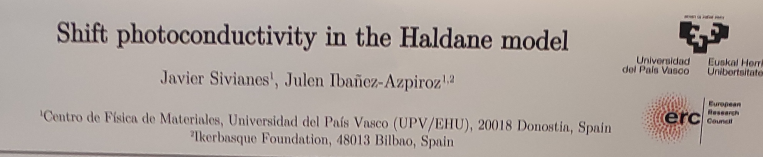

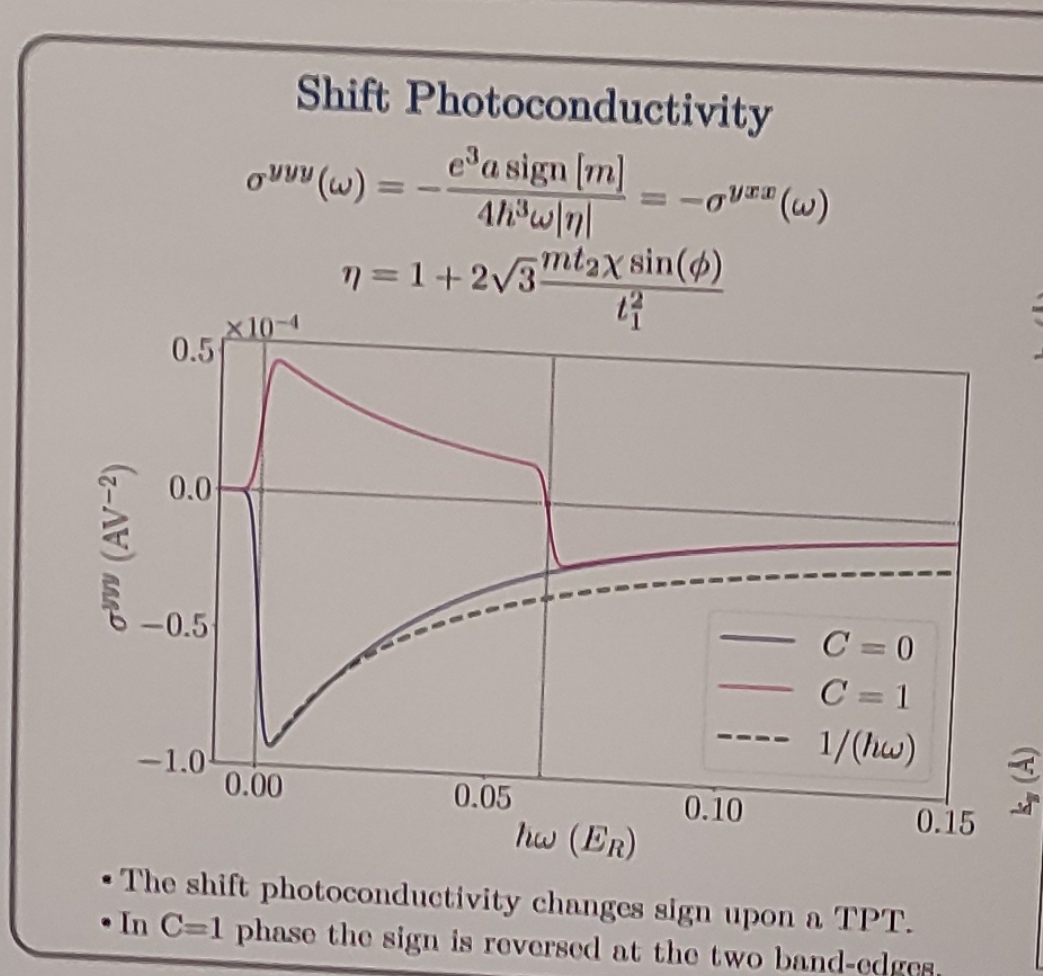

In [ ]:
model_topo = Haldane_ptb(delta=0.2, hop1=-1.0, hop2=0.15, phi=np.pi / 2)
system_haldane_topo = wberri.system.System_PythTB(model_topo,use_wcc_phase=True)

model_triv = Haldane_ptb(delta=0.2, hop1=-1.0, hop2=0.15, phi=0*np.pi / 2)
system_haldane_triv = wberri.system.System_PythTB(model_triv,use_wcc_phase=True)


result_path=wberri.run(system_haldane_triv,
                  grid=path,
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel,
                  print_Kpoints = False)

path_result = result_path.results["tabulate"]

path_result.plot_path_fat( path,
              quantity="berry",
            component="z",
        #save_file="Fe_bands+QE.pdf",
#              Eshift=EF,
#              Emin=-2,  Emax=5,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False,
              close_fig=True,
              show_fig=True,
              label = "WB"
              )

result_run_triv = wberri.run(system_haldane_triv,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            fout_name='Haldane_triv',
            print_Kpoints=False
            )

result_run_topo = wberri.run(system_haldane_topo,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            fout_name='Haldane_topo',
            print_Kpoints=False
            )

plt.close()
ahc_triv = result_run_triv.results["ahc"].data[:,2]*system_haldane_triv.real_lattice[2,2]*1e-10/pc['conductance quantum'][0]
dos_triv = result_run_triv.results["dos"].data
ahc_topo = result_run_topo.results["ahc"].data[:,2]*system_haldane_triv.real_lattice[2,2]*1e-10/pc['conductance quantum'][0]
dos_topo = result_run_topo.results["dos"].data
plt.grid()
plt.plot(Efermi_haldane,ahc_triv,label="triv")
plt.plot(Efermi_haldane,ahc_topo,label="topo")
plt.legend()
plt.show()
plt.grid()
plt.plot(Efermi_haldane,dos_triv,label="triv")
plt.plot(Efermi_haldane,dos_topo,label="topo")
plt.legend()
plt.show()


In [ ]:
omega=np.linspace(0,5,101)
Efermi_sc=np.array([-0.4])
calculators = {
               "shiftcurrent":wberri.calculators.dynamic.ShiftCurrent(
                        Efermi=Efermi_sc,
                        omega=omega,
                       sc_eta=0.05,
                   kBT=0.03,
                       kwargs_formula={"external_terms":False})
}
grid = wberri.Grid(system_haldane, NK=[20,20,1], NKFFT=[10,10,1] )

result_run_triv = wberri.run(system_haldane_triv,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            fout_name='Haldane_triv',
            print_Kpoints=False
            )

result_run_topo = wberri.run(system_haldane_topo,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            fout_name='Haldane_topo',
            print_Kpoints=False
            )

sc_topo = result_run_topo.results["shiftcurrent"].data[0,:,1,1,1]
sc_triv = result_run_triv.results["shiftcurrent"].data[0,:,1,1,1]

plt.grid()
plt.plot(omega,sc_triv,label="triv")
plt.plot(omega,sc_topo,label="topo")
plt.legend()

# Simple calculators for products


https://github.com/wannier-berri/wannier-berri/blob/8ef1b0b65d615043be6b55f231b242cfadd2f0a7/wannierberri/calculators/static.py#L411-L420


https://github.com/wannier-berri/wannier-berri/blob/8ef1b0b65d615043be6b55f231b242cfadd2f0a7/wannierberri/formula/covariant.py#L509-L512


Imagine, we want to evaluate 
$$
I_{\alpha\beta\gamma\delta} = \sum_n \int\frac{d^3k}{(2\pi)^3} m^{orb}_\alpha \Omega_\beta \frac{\partial^2\varepsilon_{nk}}{\partial k_\gamma \partial k_\delta} f
$$

In [ ]:
from wannierberri.formula import FormulaProduct
from wannierberri.formula.covariant import Omega, InvMass, morb
from wannierberri.calculators.static import StaticCalculator

class MyCrazyFormula(FormulaProduct):

    def __init__(self, data_K, **kwargs_formula):
        super().__init__([
                morb(data_K, **kwargs_formula),                 
                Omega(data_K, **kwargs_formula), 
                InvMass(data_K)], 
                name='somefunnyname')

class MyCrazyCalculator(StaticCalculator):

    def __init__(self, **kwargs):
        self.Formula = MyCrazyFormula
        self.fder = 0
        super().__init__(**kwargs)
        

calculators = { "mycalc":MyCrazyCalculator(
                        Efermi=Efermi_haldane,
                        tetra=True,
                        kwargs_formula={"external_terms":False}
                            ), }

result={}

for NK in 10,20,30,40:
    grid = wberri.Grid(system_haldane_topo, NK=NK, NKFFT=10 )
    result[NK] = wberri.run(system_haldane_topo,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
           # adpt_num_iter=20,
            fout_name='Weyl',
            )
    data = result[NK].results["mycalc"].data
    plt.plot(Efermi_haldane,data[:,2,2,1,1],".",label = f"NK={NK}")

plt.legend()
